In [110]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = True



In [4]:
import sys 
import os
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../VasModules')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver


saveFigs = False

In [3]:
from transforms import transforms
from Decon import SpectralDecon
from synthData_Gen import SyntheticData_Gen

In [48]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = np.asarray(data_d18O_LT['depth'])
d18O_LT = np.asarray(data_d18O_LT['d18O'])

#plt.plot(depth_LT,d18O_LT)
depthDif = np.diff(depth_LT)

In [49]:
def interpData(d_in, x_in, DeltaInput=False, DeltaIn=0.):
    
    d = d_in
    x = x_in
    
    if DeltaInput:
        Delta = DeltaIn
    else:
        diff = np.diff(d)
        Delta = round(min(diff), 3)

    d_min = Delta * np.ceil(d[0]/Delta)
    d_max = Delta * np.floor(d[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)

    j_arr = np.linspace(0,n,n)
    dhat0 = d_min + (j_arr - 1)*Delta

    f = interpolate.CubicSpline(d,x)

    xhat0 = f(dhat0)

    dhat = dhat0[(dhat0 >= min(d_in)) & (dhat0 <= max(d_in))]
    xhat = xhat0[(dhat0 >= min(d_in)) & (dhat0 <= max(d_in))]

    return dhat, xhat, Delta

In [50]:
d, x, delta = interpData(depth_LT, d18O_LT)

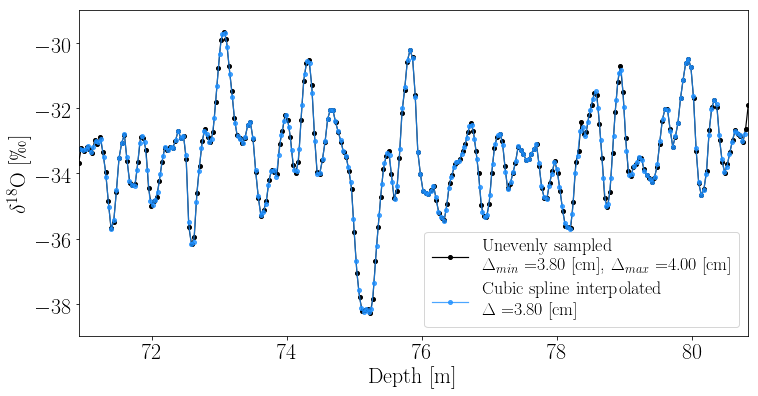

In [80]:
fig, ax = plt.subplots(figsize=(12,6))


ax.plot(depth_LT, d18O_LT, '-', marker='.', ms=8, lw=1.2, c='k', label='Unevenly sampled\n$\Delta_{min} = $' + f'{min(depthDif)*100:.2f} [cm]'+', $\Delta_{max} = $' + f'{max(depthDif)*100:.2f} [cm]')
ax.plot(d, x, '-', marker='.', ms=8,lw=1.2, label=f'Cubic spline interpolated\n$\Delta = ${delta*100:.2f} [cm]', c='dodgerblue', alpha=0.8)
ax.set(xlim=(min(depth_LT), max(depth_LT)), ylim=(-39,-29), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
ax.legend(fontsize=18)

In [22]:
np.diff(depth_LT)

array([0.044, 0.043, 0.044, 0.043, 0.044, 0.044, 0.043, 0.044, 0.043,
       0.044, 0.043, 0.043, 0.044, 0.043, 0.044, 0.043, 0.044, 0.043,
       0.043, 0.044, 0.043, 0.044, 0.043, 0.043, 0.043, 0.044, 0.043,
       0.043, 0.044, 0.043, 0.043, 0.043, 0.044, 0.043, 0.043, 0.043,
       0.044, 0.043, 0.043, 0.043, 0.043, 0.043, 0.043, 0.044, 0.043,
       0.043, 0.043, 0.043, 0.043, 0.043, 0.043, 0.043, 0.043, 0.043,
       0.043, 0.043, 0.043, 0.043, 0.043, 0.043, 0.043, 0.043, 0.043,
       0.043, 0.043, 0.042, 0.043, 0.043, 0.043, 0.043, 0.043, 0.043,
       0.042, 0.043, 0.043, 0.043, 0.043, 0.042, 0.043, 0.043, 0.043,
       0.042, 0.043, 0.043, 0.043, 0.042, 0.043, 0.043, 0.042, 0.043,
       0.042, 0.043, 0.043, 0.042, 0.043, 0.043, 0.042, 0.043, 0.042,
       0.043, 0.042, 0.043, 0.042, 0.043, 0.042, 0.043, 0.042, 0.043,
       0.042, 0.043, 0.042, 0.043, 0.042, 0.042, 0.043, 0.042, 0.043,
       0.042, 0.042, 0.043, 0.042, 0.042, 0.043, 0.042, 0.042, 0.043,
       0.042, 0.042,

# Unevenly sampled data

# Monomials

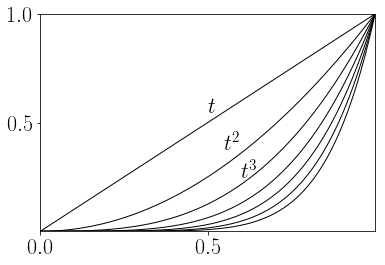

In [112]:
t = np.linspace(0,1,1000)


monoms = 8


fig, ax = plt.subplots(figsize=(6,4))
ax.set(xlim=(0,1), ylim=(0,1))
ax.text(0.5,0.55,'$t$')
ax.text(0.55,0.38,'$t^{2}$')
ax.text(0.6,0.25,'$t^{3}$')

plt.xticks(np.arange(0, 1, step=0.5)) 
plt.yticks(np.arange(0.5, 1.1, step=0.5)) 
for i in range(1,monoms):
    plt.plot(t,t**i,lw=1,c='k')
    
    
if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'Monomials.png', bbox_inches='tight')

# Linear Interpolation

# Cubic Spline Interpolation